<a href="https://colab.research.google.com/github/anustupdas/document-sucject-classification/blob/main/Final_Training_data_Exploration_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook will enable you to play with the Training data and have a good idea about the distribution of the data.


**Here we by defauilt connect to the preprocessed data So that we can demonstate the changes in the data distribution after preprocessing the Raw data.**

In [ ]:
%%capture
!pip install transformers
!pip install torch

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!unzip training_data_output_no_break.zip

Archive:  training_data_output_no_break.zip
replace training_data_output_no_break/train/token_main_data_subject_classification_summary_Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: training_data_output_no_break/train/token_main_data_subject_classification_summary_Train.csv  
replace training_data_output_no_break/test/token_main_data_subject_classification_summary_Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training_data_output_no_break/test/token_main_data_subject_classification_summary_Test.csv  
  inflating: training_data_output_no_break/dev/token_main_data_subject_classification_summary_Val.csv  


## Util Functions

In [ ]:
def get_df_from_dict(meta_dict):
  metadata_df_list = []
  mt_du = meta_dict

  for key in mt_du.keys():
    file_count = len(mt_du[key])
    max_word_count = max(mt_du[key])
    min_word_count = min(mt_du[key])
    avg_word_count = np.mean(mt_du[key])
    files_below_10_words = sum(i < 10 for i in mt_du[key])
    files_below_512_words = sum(i < 512 for i in mt_du[key])
    files_above_1000_words = sum(i > 1000 for i in mt_du[key])
    files_above_3000_words = sum(i > 3000 for i in mt_du[key])
    k = (key , file_count,max_word_count,min_word_count,int(avg_word_count),files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words)
    metadata_df_list.append(k)

  metadata_df = pd.DataFrame(metadata_df_list, columns=['Category','file_count','max_word_count', 'min_word_count','avg_word_count','files_below_10_words','files_below_512_words','files_above_1000_words','files_above_3000_words'])
  return metadata_df

def get_metadata_from_df(data_frame):

  metadata_dict = {}
  for index, row in data_frame.iterrows():
    #print(row['category'], row['count'])
    if row['category'] not in metadata_dict.keys():
      metadata_dict[row['category']] = []
    metadata_dict[row['category']].append(row['count'])



  return get_df_from_dict(metadata_dict)


In [ ]:
def plot_bar_chart(metadata_df, key_to_sort, small_first= False):

  metadata_df = metadata_df.sort_values(key_to_sort, ascending=small_first)
  category_count = metadata_df['Category'].value_counts()

  categories = category_count.index

  fig = plt.figure(figsize= (120, 50))

  ax = fig.add_subplot(111)

  sns.barplot(x = categories, y = metadata_df[key_to_sort] )

  for a, p in enumerate(ax.patches):
      ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

  plt.xlabel('Categories', size = 15)

  plt.ylabel('The Number of News', size= 15)

  plt.xticks(size = 12)

  plt.title("The number of News by Categories" , size = 18)

  plt.show()


## Starting Point

In [ ]:

df_train = pd.read_csv("/content/drive/MyDrive/medior-data-scientist-case-study/training_data_all_clean_chucked/train/clean_subject_classification_Train.csv")
df_dev = pd.read_csv("/content/drive/MyDrive/medior-data-scientist-case-study/training_data_all_clean_chucked/dev/clean_subject_classification_Val.csv")
df_test = pd.read_csv("/content/drive/MyDrive/medior-data-scientist-case-study/training_data_all_clean_chucked/test/clean_subject_classification_Test.csv")


df_train[:100]

,Unnamed: 0,file_name,text,summary,category
0,0,9783874.txt,things fall apart glossary of significant char...,things fall apart glossary of significant char...,English
1,1,20230408_0.txt,answered page 2 reader response tragedy make ...,answered on page reader response on tragedy ma...,English
2,2,20230408_1.txt,when jocasta found out the truth about her hus...,answered on page reader response on tragedy ma...,English
3,3,39546385_0.txt,surname1 name : name : course : date : femini...,surname1 name: name: course: date: feminist th...,English
4,4,39546385_1.txt,"due to her loneliness and unhappiness, janie r...",surname1 name: name: course: date: feminist th...,English
...,...,...,...,...,...
95,95,2197477_32.txt,q) go on a boat trip and jump in!18. like play...,big grammar book matt purland 101 worksheets ...,English
96,96,2197477_33.txt,"14 to be: i am, you are, he is, she is, it is,...",big grammar book matt purland 101 worksheets ...,English
97,97,2197477_34.txt,9. my doctor is getting a new receptionist.cal...,big grammar book matt purland 101 worksheets ...,English
98,98,2197477_35.txt,"for more fun worksheets, games and quizzes log...",big grammar book matt purland 101 worksheets ...,English


# Histogram of the count of text

<Axes: xlabel='category'>

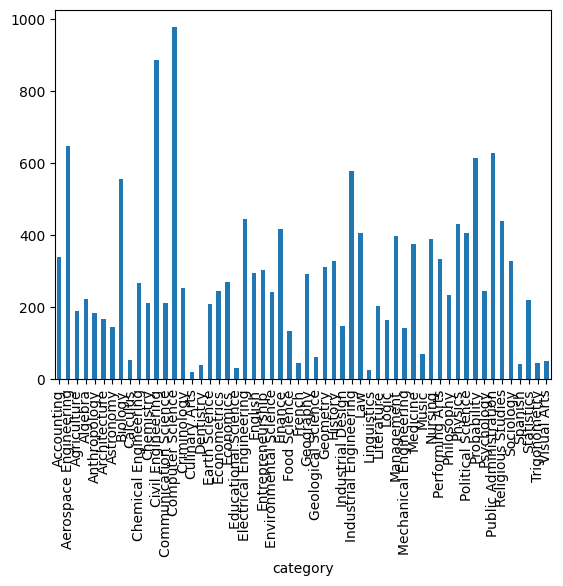

In [ ]:
df_train.groupby(['category']).size().plot.bar()

In [ ]:
df_train['count'] = df_train['text'].apply(lambda x: len(nltk.word_tokenize(str(x))))
df_train['summary_count'] = df_train['summary'].apply(lambda x: len(str(x).split()))

**Text file which had more than 550 words are boken into subtext file in order to capture the entire essence of the Subject topic file.**


In [ ]:
df_train[107:117]

,Unnamed: 0,file_name,text,summary,category,count,summary_count
107,107,9225494.txt,Pj Chavez 3 September 2020 English 101 Profess...,pj chavez september 2020 english 101 professor...,English,345,33
108,108,39546411_0.txt,surname 1 name instructor course date society...,surname name instructor course date society is...,English,244,30
109,109,39546411_1.txt,caroline was fearful of her husband been quite...,surname name instructor course date society is...,English,221,30
110,110,39546411_2.txt,we went past and our gate and before she reque...,surname name instructor course date society is...,English,155,30
111,111,37349014.txt,The short tale Use of William Carlos Williams...,the short tale use of william carlos williams...,English,368,28
112,112,18051269.txt,Make one cohesive paragraph from these 13 sent...,make one cohesive paragraph from these 13 sent...,English,542,31
113,113,21740328_0.txt,"appendix 2 answer keys exercises modules 1 , ...",NaN,English,400,1
114,114,21740328_1.txt,9. a position an election... a horse... the ne...,NaN,English,212,1
115,115,21740328_2.txt,pass 5. s you v s (you understood because impe...,NaN,English,533,1
116,116,21740328_3.txt,9. b leave had realized were (had been) yells ...,NaN,English,315,1


<Figure size 800x800 with 0 Axes>

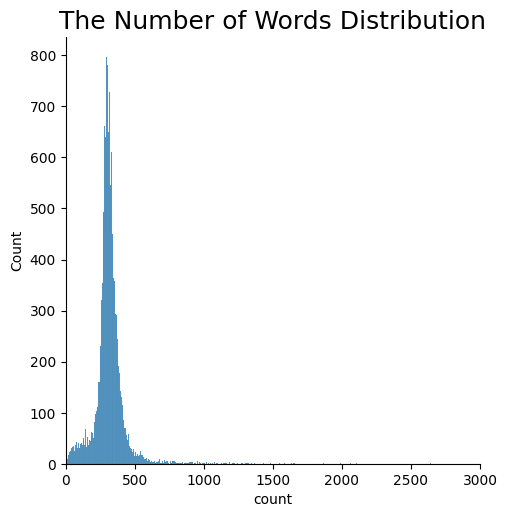

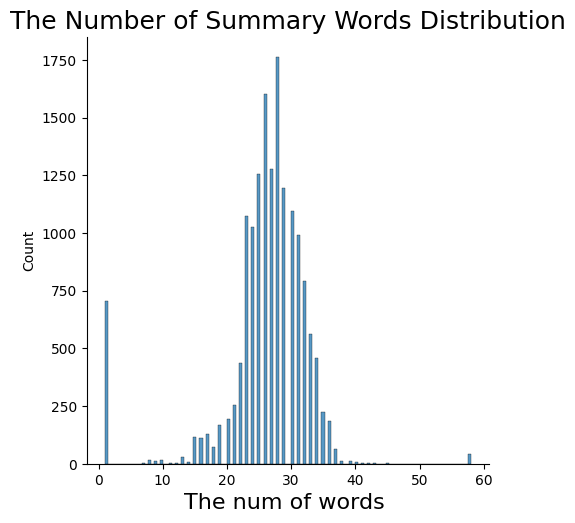

In [ ]:
plt.figure(figsize= (8, 8))


sns.displot(df_train['count'])
plt.title("The Number of Words Distribution", fontsize = 18)
sns.displot(df_train['summary_count'])
plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Summary Words Distribution", fontsize = 18)
plt.show()


**A word count distribution plot for a whole corpus is a graphical representation of the frequency of words in
the corpus, arranged according to the number of times they appear in the corpus. In this plot, the x-axis represents
 the number of times a word appears in the corpus, while the y-axis represents the number of words that appear that many times.
The plot can be used to identify the most common words in the corpus and determine the overall shape and characteristics of the corpus. It can also be compared to similar plots for other corpora to identify patterns and trends in language use.**

# Bar plot for each of the new category

In [ ]:
metadata_df = get_metadata_from_df(df_train)
metadata_df

,Category,file_count,max_word_count,min_word_count,avg_word_count,files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words
0,English,296,781,20,305,0,287,0,0
1,Dentistry,39,1187,26,358,0,35,2,0
2,Sociology,327,562,30,290,0,325,0,0
3,Accounting,338,939,31,341,0,334,0,0
4,French,45,572,1,281,3,44,0,0
5,Law,407,786,18,293,0,400,0,0
6,Industrial Design,149,891,28,317,0,147,0,0
7,Geological Science,62,754,18,321,0,53,0,0
8,Aerospace Engineering,646,1453,19,310,0,634,3,0
9,Communication Science,211,1482,23,299,0,204,3,0


Example Usage:



```
# plot_bar_chart(meta-data-frame, 'column-name-to-sort-for', small_first = False)
```



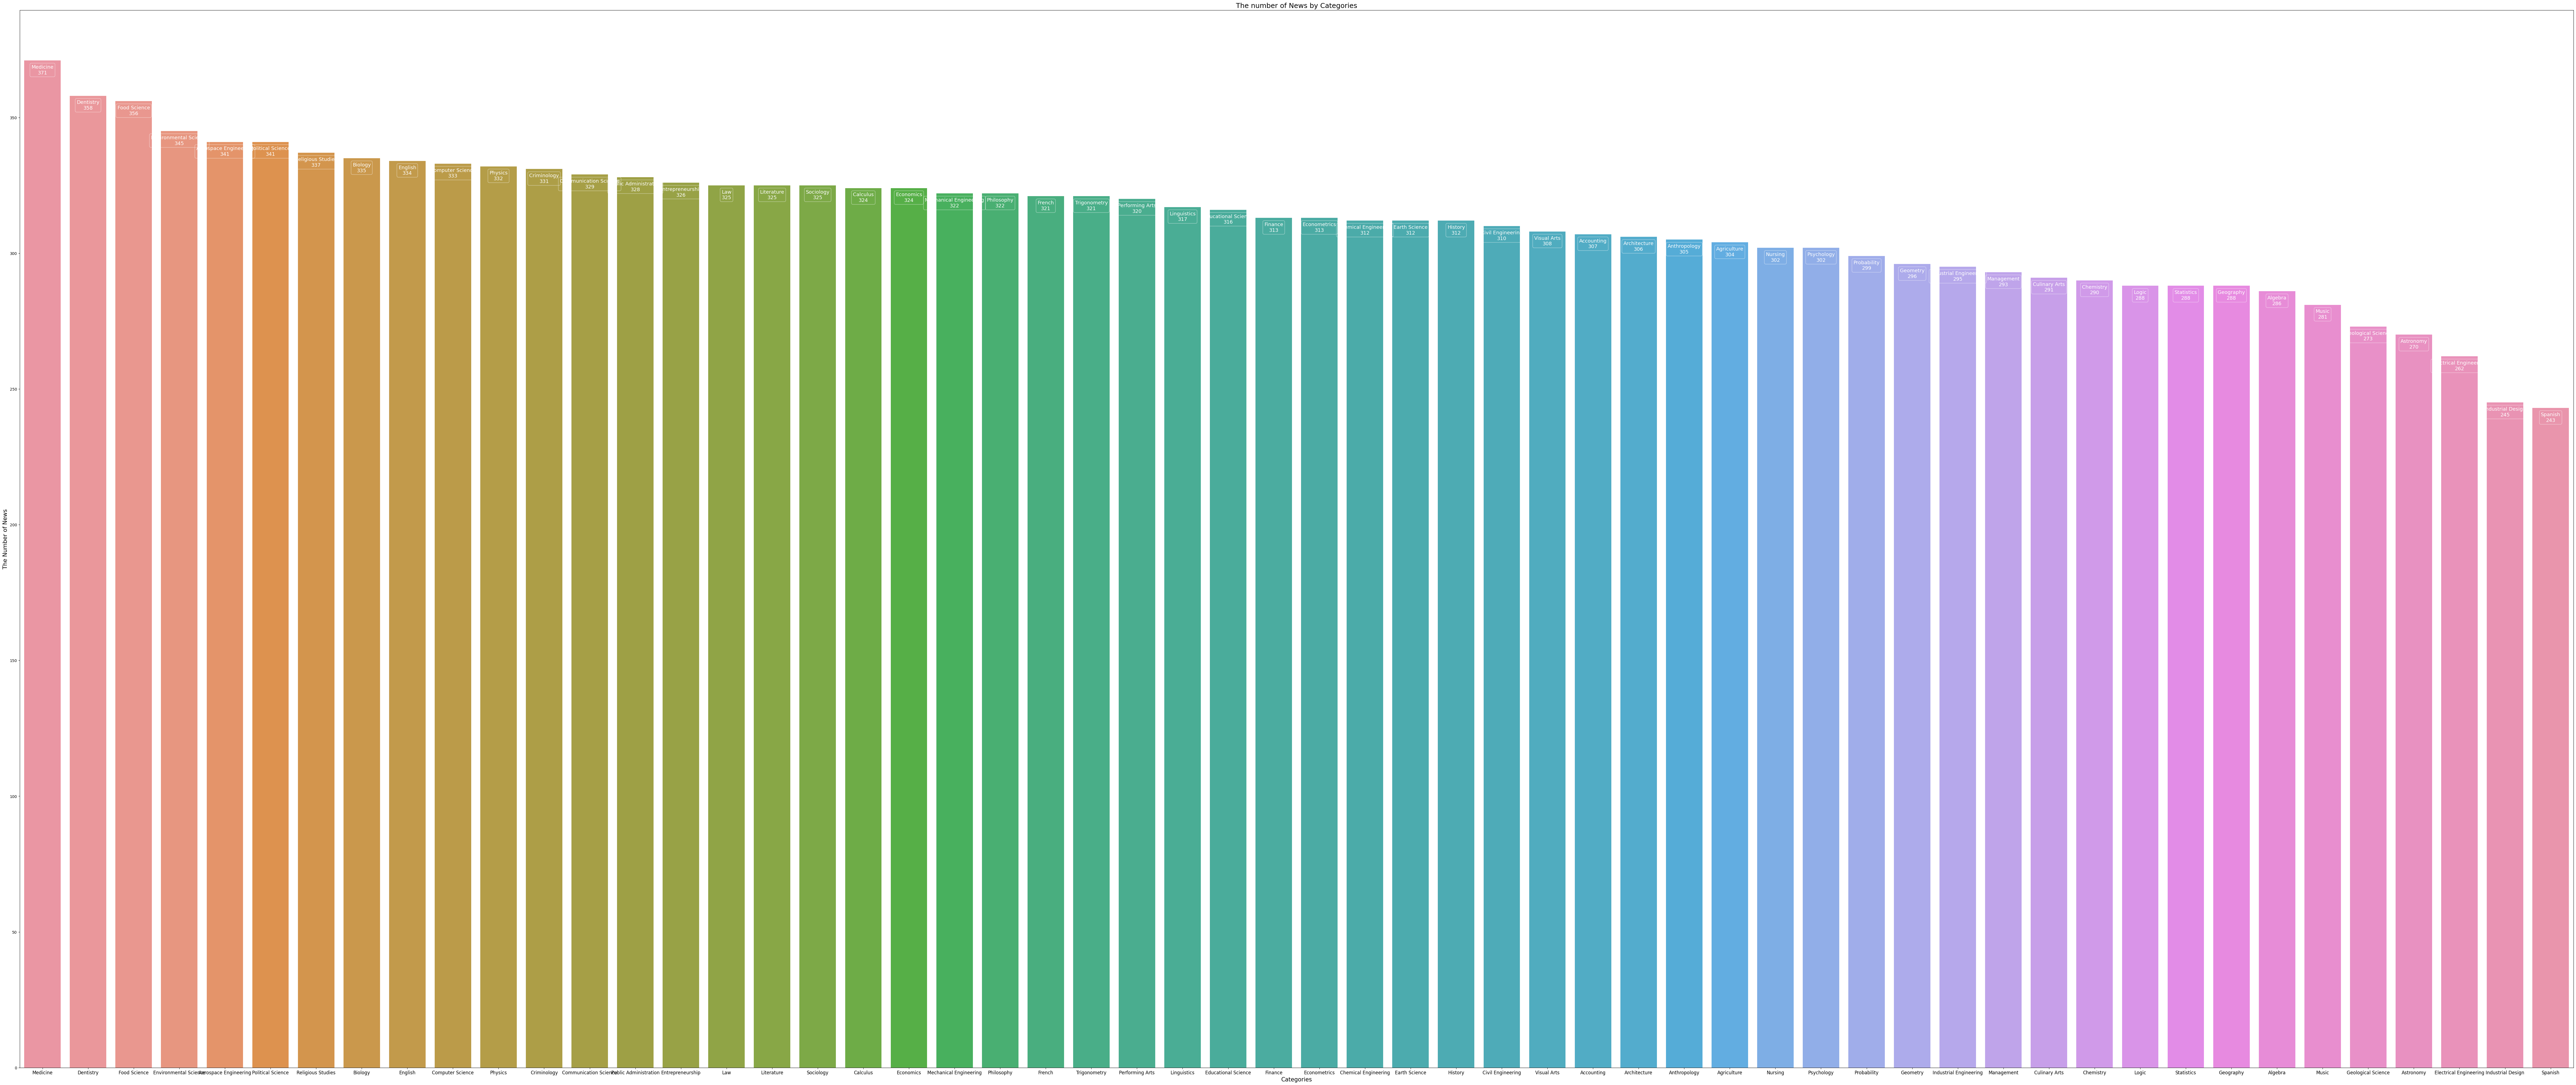

In [ ]:
plot_bar_chart(metadata_df, 'avg_word_count', small_first = False)